<a href="https://colab.research.google.com/github/monokrrome/Binary-Image-Classification-using-Attention-Mechanism-and-EfficientNet/blob/main/Binary_Image_Classification_using_Attention_Mechanism_and_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Binary Classification of Uterine Fibroid tumor images using fine tuning with EfficientNetB0 and Attention Mechanism**

### **Introduction**

EfficientNet is a convolutional neural network architecture designed to optimize both accuracy and efficiency. It was introduced by researchers at Google AI in 2019. The key idea behind EfficientNet is to scale the network's depth, width, and resolution simultaneously to achieve better performance without significantly increasing computational cost.


EfficientNet uses a compound scaling method that uniformly scales the network dimensions (depth, width, and resolution) by a fixed ratio. This approach ensures that the model is well-balanced and efficient across different scales.


EfficientNet-B0 specifically refers to the baseline model in the EfficientNet family. It has relatively fewer parameters compared to larger variants like EfficientNet-B1, B2, etc., making it suitable for tasks where computational resources are limited, such as on mobile devices or edge devices.


EfficientNet-B0 is trained with the same scaling method as other variants but starts with a smaller baseline architecture. It achieves a good balance between computational cost and accuracy, making it a popular choice for various computer vision tasks.


"An attention mechanism is an Encoder-Decoder kind of neural network architecture that allows the model to focus on specific sections of the input while executing a task. It dynamically assigns weights to different elements in the input, indicating their relative importance or relevance. By incorporating attention, the model can selectively attend to and process the most relevant information, capturing dependencies and relationships within the data." (via GeeksforGeeks)

### **Technical Approach**

By referring to ‘Image classification via fine-tuning with EfficientNet’ by Yixing Fu provided by the official Keras github repository and documentation, I planned to do a keras implementation of EfficientNet on custom uterus fibroid dataset.
This model takes input images of shape (224, 224, 3), and the input data should be in the range [0, 255]. Normalization is included as part of the model.


Because training EfficientNet on ImageNet takes a tremendous amount of resources and several techniques that are not a part of the model architecture itself. Hence the Keras implementation by default loads pre-trained weights obtained via training with AutoAugment.


For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:


**Base model - resolution**

EfficientNetB0 - 224

EfficientNetB1 - 240

EfficientNetB2 - 260

EfficientNetB3 - 300

EfficientNetB4 - 380

EfficientNetB5 - 456

EfficientNetB6 - 528

EfficientNetB7 - 600

When the model is intended for transfer learning, the Keras implementation provides a option to remove the top layers:
model = EfficientNetB0(include_top=False, weights='imagenet')


#### **Self Attention Mechanism**

-The self-attention mechanism is added directly after the base model's
output.

-The attention weights are used to scale the features extracted by the base model.

-The model outputs these scaled features instead of applying additional layers for classification.

-The model is compiled and trained using the extracted features.


#### **Installing and importing Necessary Libraries**



In [2]:
!pip install opencv-python
!pip install tensorflow_hub

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import glob
from keras import layers
from keras.applications import EfficientNetB0

####**Loading Data**

We are loading data from our custom dataset stored on google drive. The dataset contains 1990 photos belonging to two classes - NUF(Non-Uterine Fibroid) and UF(Uterine Fibroid) – (1594 for training and 396 files for testing).

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the path to your dataset directory
train_data_dir = '/content/drive/MyDrive/datasets/train'
test_data_dir = '/content/drive/MyDrive/datasets/test'

**Data Preprocessing and Data Augmentation**

In [6]:
# Define the number of classes
NUM_CLASSES = 2  # Non-uterine fibroid and uterine fibroid

# Define image size
IMG_SIZE = 224

# Define batch size
BATCH_SIZE = 64

# Define data augmentation and preprocessing functions
img_augmentation = tf.keras.Sequential([
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
])

def preprocess_image(image_path):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image

def preprocess_label(image_path, label):
    # Convert label to integer (0 or 1)
    label = tf.cast(label, tf.int32)
    # Convert label to one-hot encoding
    return preprocess_image(image_path), tf.one_hot(label, NUM_CLASSES)

**Prepare Input**

In [7]:
# Prepare train dataset
train_dataset = tf.data.Dataset.list_files(train_data_dir + '/*/*.jpg')
train_dataset = train_dataset.map(lambda x: (x, tf.strings.split(x, os.path.sep)[-2] == 'uf'))
train_dataset = train_dataset.map(lambda x, y: preprocess_label(x, y))  # Preprocess both image and label
train_dataset = train_dataset.map(lambda x, y: (img_augmentation(x), y))
train_dataset = train_dataset.batch(BATCH_SIZE)

# Prepare test dataset
test_dataset = tf.data.Dataset.list_files(test_data_dir + '/*/*.jpg')
test_dataset = test_dataset.map(lambda x: (x, tf.strings.split(x, os.path.sep)[-2] == 'uf'))
test_dataset = test_dataset.map(lambda x, y: preprocess_label(x, y))  # Preprocess both image and label
test_dataset = test_dataset.batch(BATCH_SIZE)

**Building the Model**

In [8]:
# Load EfficientNet with pre-trained ImageNet weights
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add self-attention mechanism
# Define the model architecture
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)  # Extract features from the base model
attention_probs = layers.Dense(1, activation='softmax')(x)
attention_mul = layers.Multiply()([x, attention_probs])
features = tf.keras.layers.GlobalAveragePooling2D()(attention_mul)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(features)  # Classification layer

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.000001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


**Get the Model Summary**

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_2[0][0]']             
 )                                                                                                
                                                                                                  
 dense (Dense)               (None, 7, 7, 1)              1281      ['efficientnetb0[0][0]']      
                                                                                                  
 multiply (Multiply)         (None, 7, 7, 1280)           0         ['efficientnetb0[0][0]',  

**Train the Model**

In [10]:
# Train the model
epochs = 6
hist = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/6
27/27 [==============================] - 778s 25s/step - loss: 1.0254 - accuracy: 0.1992 - val_loss: 1.3274 - val_accuracy: 0.0451
Epoch 2/6
27/27 [==============================] - 584s 22s/step - loss: 0.7800 - accuracy: 0.4584 - val_loss: 1.1232 - val_accuracy: 0.1028
Epoch 3/6
27/27 [==============================] - 543s 20s/step - loss: 0.6175 - accuracy: 0.6779 - val_loss: 0.9497 - val_accuracy: 0.2030
Epoch 4/6
27/27 [==============================] - 536s 20s/step - loss: 0.4828 - accuracy: 0.8480 - val_loss: 0.8078 - val_accuracy: 0.3784
Epoch 5/6
27/27 [==============================] - 526s 19s/step - loss: 0.3860 - accuracy: 0.9394 - val_loss: 0.6949 - val_accuracy: 0.5689
Epoch 6/6
27/27 [==============================] - 529s 20s/step - loss: 0.3117 - accuracy: 0.9720 - val_loss: 0.6025 - val_accuracy: 0.6942


**Plot Training History**

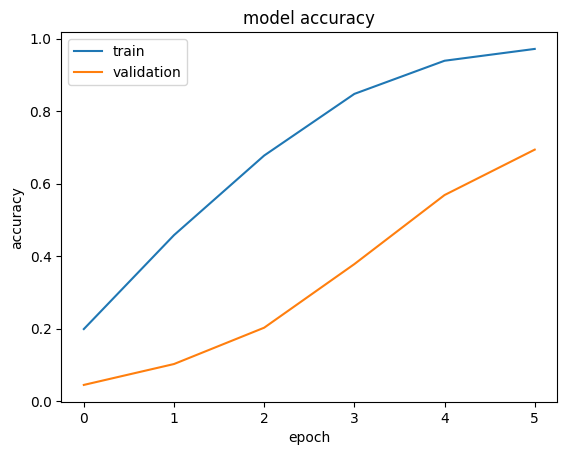

In [11]:
# Plot training history
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

### **Hyperparameter Tuning**

I experimented with reducing the dropout rate because of the following:
1. **Simple Models**: For simpler models with fewer parameters or layers, using low dropout rates (e.g., 0.1 or lower) may be sufficient for regularization without excessively reducing the model's capacity. I set the dropout rate to 0.1.
2. **Small Datasets**: In scenarios where the dataset is relatively small, using low dropout rates can help prevent overfitting without overly constraining the model's learning capacity. Our dataset is also small.

I reduced the number of epochs to 6 epochs to slow the convergence and prevent overfitting to allow for finer adjustments to the weights and biases during training.

I also set the learning rate to 0.00005 for the following reasons:
1. **Stability**: Lower learning rates often result in a more stable optimization process, as the updates to the parameters are smaller and less likely to lead to divergence.
2. **Precise convergence**: With a lower learning rate, the optimization algorithm takes smaller steps towards the minimum point, potentially allowing it to find a more precise solution.

### **References**

1. https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb
2. https://github.com/keras-team/keras-io/tree/master
3. https://arxiv.org/abs/1805.09501